<a href="https://colab.research.google.com/github/mufeedac/py/blob/master/air_quality_lime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=00a226fdd676556851d490fff73a2d470d564ab690152251818f1ff856f3c524
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
# Importing necessary libraries
import os
import math
#import shap
import pandas as pd
import numpy as np
import seaborn as sns;
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from numpy import array
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.layers import LSTM
from keras.layers import Dense,Dropout
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

In [ ]:
#Read the daily city-wise data
pollution_data = pd.read_csv("/content/city_day.csv",parse_dates=True)
# df['utc_time'] = pd.to_datetime(df['utc_time'])



In [ ]:
# Display the first few rows of the DataFrame
pollution_data.tail()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
29526,Visakhapatnam,2020-06-27,15.02,50.94,7.68,25.06,19.54,12.47,0.47,8.55,23.30,2.24,12.07,0.73,41.0,Good
29527,Visakhapatnam,2020-06-28,24.38,74.09,3.42,26.06,16.53,11.99,0.52,12.72,30.14,0.74,2.21,0.38,70.0,Satisfactory
29528,Visakhapatnam,2020-06-29,22.91,65.73,3.45,29.53,18.33,10.71,0.48,8.42,30.96,0.01,0.01,0.00,68.0,Satisfactory
29529,Visakhapatnam,2020-06-30,16.64,49.97,4.05,29.26,18.80,10.03,0.52,9.84,28.30,0.00,0.00,0.00,54.0,Satisfactory
29530,Visakhapatnam,2020-07-01,15.00,66.00,0.40,26.85,14.05,5.20,0.59,2.10,17.05,NaN,NaN,NaN,50.0,Good


In [ ]:
#filter the data between 2018 to 2020
pollution_data['Date'] = pd.to_datetime(pollution_data['Date'])  # convert date_column to datetime format
start_date = '2018-01-01'
end_date = '2020-12-31'
ftd_pollution_data = pollution_data[(pollution_data['Date'] >= start_date) & (pollution_data['Date'] <= end_date)]

In [ ]:
# summary of the data
ftd_pollution_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18563 entries, 1096 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   City        18563 non-null  object        
 1   Date        18563 non-null  datetime64[ns]
 2   PM2.5       17139 non-null  float64       
 3   PM10        14695 non-null  float64       
 4   NO          17491 non-null  float64       
 5   NO2         17489 non-null  float64       
 6   NOx         17082 non-null  float64       
 7   NH3         14583 non-null  float64       
 8   CO          17609 non-null  float64       
 9   SO2         17308 non-null  float64       
 10  O3          17249 non-null  float64       
 11  Benzene     15479 non-null  float64       
 12  Toluene     12923 non-null  float64       
 13  Xylene      7056 non-null   float64       
 14  AQI         17216 non-null  float64       
 15  AQI_Bucket  17216 non-null  object        
dtypes: datetime64[ns](1

In [ ]:
#creates a new DataFrame called pm_data by selecting specific columns ('PM10', 'PM2.5', 'AQI')

pm_data=ftd_pollution_data[['PM10','PM2.5','AQI']]
#pm_data = pm_data.set_index('Datetime')

In [ ]:
# Check for the count of missing values in each column of pm_data
pm_data.isnull().sum()

PM10     3868
PM2.5    1424
AQI      1347
dtype: int64

In [ ]:
# Check for the count of NaN values in each column of pm_data
pm_data.isna().sum()

PM10     3868
PM2.5    1424
AQI      1347
dtype: int64

In [ ]:
pm_data.shape

(18563, 3)

In [ ]:
# Drop rows with missing values from pm_data DataFrame
pm_data.dropna(inplace=True)

<ipython-input-11-9f87d74cd1cc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pm_data.dropna(inplace=True)


In [ ]:
pm_data.shape

(13746, 3)

In [ ]:
pm_data.head()

,PM10,PM2.5,AQI
1595,122.41,37.55,281.0
1596,116.32,33.97,330.0
1597,130.07,35.48,356.0
1598,138.31,34.11,359.0
1599,111.73,33.69,547.0


<Axes: >

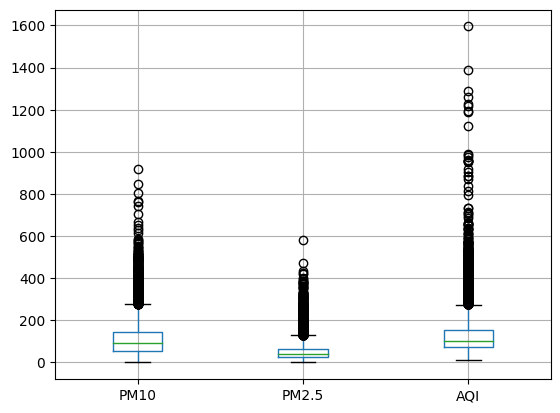

In [ ]:
pm_data.boxplot()

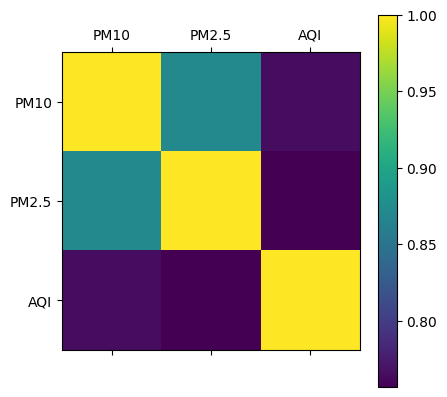

In [ ]:
dataset_columns = pm_data.columns.tolist()
cor_cols = dataset_columns
plt.matshow(pm_data.corr())
plt.xticks(range(len(cor_cols)), cor_cols)
plt.yticks(range(len(cor_cols)), cor_cols)
plt.colorbar()
plt.show()

In [ ]:
values_pm = pm_data.values

In [ ]:
#  Scaling the all of the data to be values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_pm_data = scaler.fit_transform(values_pm)
scaled_pm_data


array([[0.13330789, 0.06442361, 0.16888046],
       [0.12666594, 0.05827494, 0.1998735 ],
       [0.14166212, 0.06086837, 0.21631879],
       ...,
       [0.07149089, 0.03927933, 0.0341556 ],
       [0.05430254, 0.02851058, 0.02530044],
       [0.07178536, 0.02569387, 0.0227704 ]])

In [ ]:
#Creating a window for previous data
def to_supervised(train):
  window_size = 60
  X = []
  Y = []
  for i in range(window_size, len(train)):
    X.append(train[i-window_size:i,:])
    Y.append(train[i,0:1])

  return X,Y

In [ ]:
X, Y = to_supervised(scaled_pm_data)
X = np.array(X)
Y = np.array(Y)
print('Y' ,Y.shape)
print('X' ,X.shape)

Y (13686, 1)
X (13686, 60, 3)


In [ ]:
#Splitting the dataset
#n_train = int(0.9*17142)
n_train = math.ceil( len(pm_data) *.8)

X_test, X_train = X[n_train:,] , X[:n_train,]
print('X_train' ,X_train.shape)
print('X_test' ,X_test.shape)

Y_test, Y_train = Y[n_train:,] , Y[:n_train,]
print('Y_train' ,Y_train.shape)
print('Y_test' ,Y_test.shape)

X_train (10997, 60, 3)
X_test (2689, 60, 3)
Y_train (10997, 1)
Y_test (2689, 1)


In [ ]:
#Importing LSTM model
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))



In [ ]:
# here we are Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# here we are training the model
model.fit(X_train, Y_train, batch_size=1, epochs=5)

Epoch 1/5
10997/10997 [==============================] - 126s 11ms/step - loss: 0.0030
Epoch 2/5
10997/10997 [==============================] - 115s 10ms/step - loss: 0.0024
Epoch 3/5
10997/10997 [==============================] - 116s 11ms/step - loss: 0.0023
Epoch 4/5
10997/10997 [==============================] - 119s 11ms/step - loss: 0.0022
Epoch 5/5
10997/10997 [==============================] - 125s 11ms/step - loss: 0.0022


In [ ]:
features = ['pm2.5','pm10','AQI']

In [ ]:
explainer = lime_tabular.RecurrentTabularExplainer(X_train feature_names=data_columns,
                                                   discretize_continuous=True,
                                                   class_names=['Falling', 'Rising'],
                                                   discretizer='decile')

In [ ]:
# Importing the module for LimeTabularExplainer
from lime import lime_tabular

# Instantiating the explainer object by passing in the training set,
# and the extracted features
explainer_lime = lime_tabular.RecurrentTabularExplainer(X_train,
												feature_names=features,
												verbose=True,
												mode='regression')


In [ ]:
# Index corresponding to the test vector
i = 10

# Number denoting the top features
k = 2

# Calling the explain_instance method by passing in the:
#    1) ith test vector
#    2) prediction function used by our prediction model('reg' in this case)
#    3) the top features which we want to see, denoted by k

exp_lime = explainer_lime.explain_instance(
    X_test[i], model.predict, num_features=k)

# Finally visualizing the explanations
exp_lime.show_in_notebook()

157/157 [==============================] - 2s 5ms/step
Intercept 0.15371660754139496
Prediction_local [0.09733279]
Right: 0.09651773


In [ ]:
Y_pred = model.predict(X_test)

85/85 [==============================] - 1s 5ms/step


In [ ]:

mae = mean_absolute_error(Y_test, Y_pred)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error:",mse)
print("Root Mean Squared Error:", rmse)

r2 = r2_score(Y_test, Y_pred)
print("R-squared score:", r2)


Mean Absolute Error: 0.02529276628661104
Mean Squared Error: 0.0016198951162899574
Root Mean Squared Error: 0.04024792064554338
R-squared score: 0.8149622413561133


In [ ]:
#Y_predicted = scaler.inverse_transform(Y_pred)
print('y_predicted',Y_pred.shape)
#print('X_train' ,X_train.shape)
print('X_test' ,X_test.shape)
print('Y_test',Y_test.shape)

y_predicted (2689, 1)
X_test (2689, 60, 3)
Y_test (2689, 1)


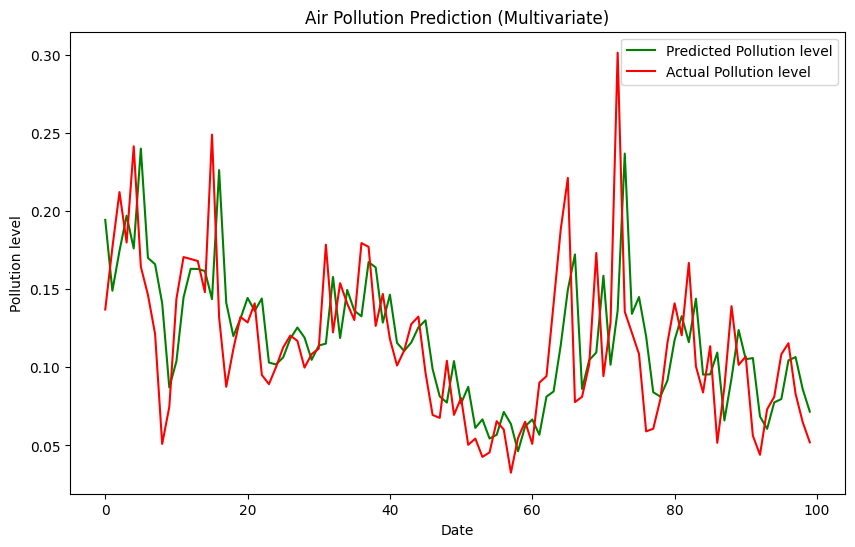

<Figure size 640x480 with 0 Axes>

In [ ]:
#Plot the graph between actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(Y_pred[:100,:], color= 'green',label = 'Predicted Pollution level')
plt.plot(Y_test[:100,:] , color = 'red',label = 'Actual Pollution level')
plt.title("Air Pollution Prediction (Multivariate)")
plt.xlabel("Date")
plt.ylabel("Pollution level")
plt.legend()
plt.show()
plt.savefig('graph.png')

SHAP


In [ ]:
!pip install --upgrade shap


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features)


In [ ]:
#creates a new DataFrame called mt_data by selecting specific columns ('PM10', 'PM2.5', 'AQI')

mt_data=ftd_pollution_data[['NO','NO2','NOx','NH3','CO','SO2','O3','AQI']]


In [ ]:
# Check for the count of missing values in each column of pm_data
mt_data.isnull().sum()

NO     1072
NO2    1074
NOx    1481
NH3    3980
CO      954
SO2    1255
O3     1314
AQI    1347
dtype: int64

In [ ]:
# Check for the count of NaN values in each column of pm_data
mt_data.isna().sum()

NO     1072
NO2    1074
NOx    1481
NH3    3980
CO      954
SO2    1255
O3     1314
AQI    1347
dtype: int64

In [ ]:
# Drop rows with missing values from pm_data DataFrame
mt_data.dropna(inplace=True)

<ipython-input-34-e9d4c8344b5b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mt_data.dropna(inplace=True)


In [ ]:
mt_data.shape

(12725, 8)

In [ ]:
mt_data.head()

,NO,NO2,NOx,NH3,CO,SO2,O3,AQI
2010,7.20,1.27,10.65,25.63,0.56,4.22,2.81,52.0
2011,7.19,0.91,10.37,29.16,0.57,4.46,0.18,60.0
2012,7.14,1.07,10.48,28.95,0.57,4.53,0.41,62.0
2013,7.09,0.36,9.73,28.41,0.48,4.63,0.30,70.0
2014,5.63,2.32,8.09,23.98,0.50,4.71,13.02,54.0


<Axes: >

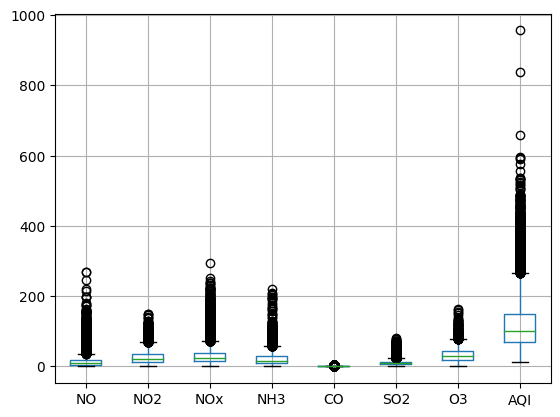

In [ ]:
mt_data.boxplot()

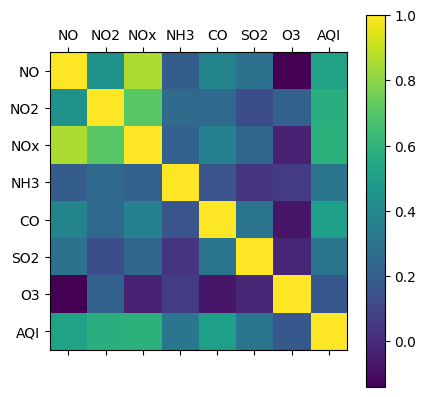

In [ ]:
dataset_columns = mt_data.columns.tolist()
cor_cols = dataset_columns
plt.matshow(mt_data.corr())
plt.xticks(range(len(cor_cols)), cor_cols)
plt.yticks(range(len(cor_cols)), cor_cols)
plt.colorbar()
plt.show()

In [ ]:
values_mt = mt_data.values

In [ ]:
#  Scaling the all of the data to be values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_mt_data = scaler.fit_transform(values_mt)
scaled_mt_data


array([[0.025756  , 0.0084    , 0.03564478, ..., 0.05274367, 0.01724988,
        0.0403397 ],
       [0.02571894, 0.006     , 0.03468879, ..., 0.05575044, 0.00104731,
        0.04883227],
       [0.02553365, 0.00706667, 0.03506436, ..., 0.05662741, 0.00246427,
        0.05095541],
       ...,
       [0.01185888, 0.1968    , 0.06186623, ..., 0.10536206, 0.19067275,
        0.05732484],
       [0.01408242, 0.195     , 0.06347093, ..., 0.12315209, 0.17428536,
        0.04246285],
       [0.00055588, 0.17893333, 0.04725324, ..., 0.02618391, 0.10497782,
        0.03821656]])

In [ ]:
X, Y = to_supervised(scaled_mt_data)
X = np.array(X)
Y = np.array(Y)
print('Y' ,Y.shape)
print('X' ,X.shape)

Y (12665, 1)
X (12665, 60, 8)


In [ ]:
#Splitting the dataset
#n_train = int(0.9*17142)
n_train = math.ceil( len(mt_data) *.8)

X_test, X_train = X[n_train:,] , X[:n_train,]
print('X_train' ,X_train.shape)
print('X_test' ,X_test.shape)

Y_test, Y_train = Y[n_train:,] , Y[:n_train,]
print('Y_train' ,Y_train.shape)
print('Y_test' ,Y_test.shape)

X_train (10180, 60, 8)
X_test (2485, 60, 8)
Y_train (10180, 1)
Y_test (2485, 1)


In [ ]:
#Importing LSTM model
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))



In [ ]:
# here we are Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# here we are training the model
model.fit(X_train, Y_train, batch_size=1, epochs=5)

Epoch 1/5
10180/10180 [==============================] - 109s 10ms/step - loss: 0.0028
Epoch 2/5
10180/10180 [==============================] - 109s 11ms/step - loss: 0.0022
Epoch 3/5
10180/10180 [==============================] - 132s 13ms/step - loss: 0.0020
Epoch 4/5
10180/10180 [==============================] - 112s 11ms/step - loss: 0.0019
Epoch 5/5
10180/10180 [==============================] - 104s 10ms/step - loss: 0.0018


In [ ]:
Y_pred = model.predict(X_test)

78/78 [==============================] - 1s 6ms/step


In [ ]:

mae = mean_absolute_error(Y_test, Y_pred)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error:",mse)
print("Root Mean Squared Error:", rmse)

r2 = r2_score(Y_test, Y_pred)
print("R-squared score:", r2)


Mean Absolute Error: 0.03535274446550616
Mean Squared Error: 0.0030560064655428547
Root Mean Squared Error: 0.05528115832309282
R-squared score: 0.5231281632375645


In [ ]:
#Y_predicted = scaler.inverse_transform(Y_pred)
print('y_predicted',Y_pred.shape)
#print('X_train' ,X_train.shape)
print('X_test' ,X_test.shape)
print('Y_test',Y_test.shape)

y_predicted (2485, 1)
X_test (2485, 60, 8)
Y_test (2485, 1)


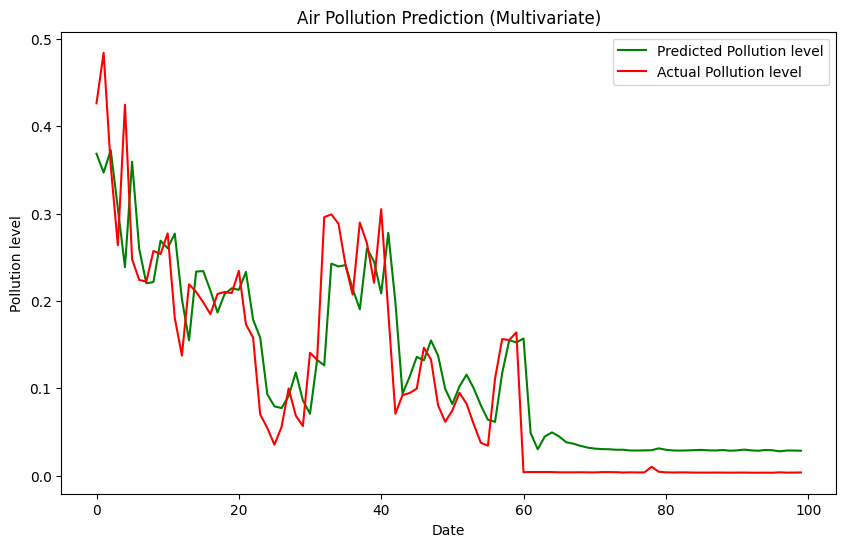

<Figure size 640x480 with 0 Axes>

In [ ]:
#Plot the graph between actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(Y_pred[:100,:], color= 'green',label = 'Predicted Pollution level')
plt.plot(Y_test[:100,:] , color = 'red',label = 'Actual Pollution level')
plt.title("Air Pollution Prediction (Multivariate)")
plt.xlabel("Date")
plt.ylabel("Pollution level")
plt.legend()
plt.show()
plt.savefig('graph.png')

In [ ]:
#creates a new DataFrame called mt_data by selecting specific columns ('PM10', 'PM2.5', 'AQI')

cmb_data=ftd_pollution_data[['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','AQI']]


In [ ]:
# Check for the count of missing values in each column of pm_data
cmb_data.isnull().sum()

PM2.5    1424
PM10     3868
NO       1072
NO2      1074
NOx      1481
NH3      3980
CO        954
SO2      1255
O3       1314
AQI      1347
dtype: int64

In [ ]:
# Check for the count of NaN values in each column of pm_data
cmb_data.isna().sum()

PM2.5    1424
PM10     3868
NO       1072
NO2      1074
NOx      1481
NH3      3980
CO        954
SO2      1255
O3       1314
AQI      1347
dtype: int64

In [ ]:
# Drop rows with missing values from pm_data DataFrame
cmb_data.dropna(inplace=True)

<ipython-input-33-43c5583a501a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cmb_data.dropna(inplace=True)


In [ ]:
cmb_data.shape

(11093, 10)

In [ ]:
cmb_data.head()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,AQI
2010,31.21,38.66,7.20,1.27,10.65,25.63,0.56,4.22,2.81,52.0
2011,38.39,46.68,7.19,0.91,10.37,29.16,0.57,4.46,0.18,60.0
2012,43.23,50.83,7.14,1.07,10.48,28.95,0.57,4.53,0.41,62.0
2013,33.82,41.03,7.09,0.36,9.73,28.41,0.48,4.63,0.30,70.0
2014,27.14,35.04,5.63,2.32,8.09,23.98,0.50,4.71,13.02,54.0


<Axes: >

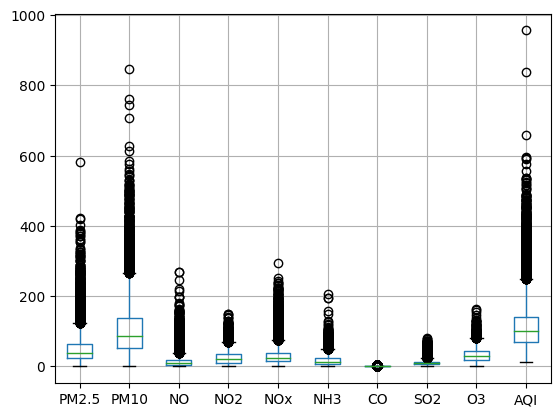

In [ ]:
cmb_data.boxplot()

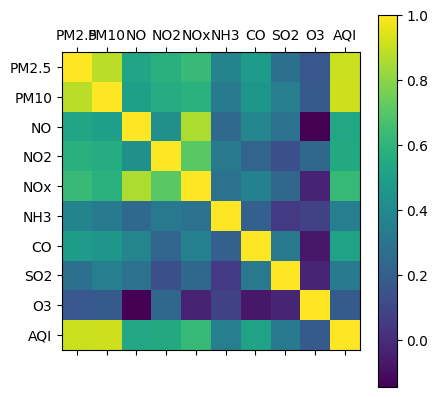

In [ ]:
dataset_columns = cmb_data.columns.tolist()
cor_cols = dataset_columns
plt.matshow(cmb_data.corr())
plt.xticks(range(len(cor_cols)), cor_cols)
plt.yticks(range(len(cor_cols)), cor_cols)
plt.colorbar()
plt.show()

In [ ]:
values_cmb= cmb_data.values

In [ ]:
#  Scaling the all of the data to be values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_cmb_data = scaler.fit_transform(values_cmb)
scaled_cmb_data


array([[0.05333952, 0.0454186 , 0.025756  , ..., 0.05274367, 0.01724988,
        0.0403397 ],
       [0.06567374, 0.05488474, 0.02571894, ..., 0.05575044, 0.00104731,
        0.04883227],
       [0.07398818, 0.05978306, 0.02553365, ..., 0.05662741, 0.00246427,
        0.05095541],
       ...,
       [0.03908129, 0.07736978, 0.01185888, ..., 0.10536206, 0.19067275,
        0.05732484],
       [0.02831031, 0.05876799, 0.01408242, ..., 0.12315209, 0.17428536,
        0.04246285],
       [0.02549303, 0.07768847, 0.00055588, ..., 0.02618391, 0.10497782,
        0.03821656]])

In [ ]:
X, Y = to_supervised(scaled_cmb_data)
X = np.array(X)
Y = np.array(Y)
print('Y' ,Y.shape)
print('X' ,X.shape)

Y (11033, 1)
X (11033, 60, 10)


In [ ]:
#Splitting the dataset
#n_train = int(0.9*17142)
n_train = math.ceil( len(cmb_data) *.8)

X_test, X_train = X[n_train:,] , X[:n_train,]
print('X_train' ,X_train.shape)
print('X_test' ,X_test.shape)

Y_test, Y_train = Y[n_train:,] , Y[:n_train,]
print('Y_train' ,Y_train.shape)
print('Y_test' ,Y_test.shape)

X_train (8875, 60, 10)
X_test (2158, 60, 10)
Y_train (8875, 1)
Y_test (2158, 1)


In [ ]:
#Importing LSTM model
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))



In [ ]:
# here we are Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# here we are training the model
model.fit(X_train, Y_train, batch_size=1, epochs=5)

Epoch 1/5
8875/8875 [==============================] - 90s 10ms/step - loss: 0.0025
Epoch 2/5
8875/8875 [==============================] - 86s 10ms/step - loss: 0.0018
Epoch 3/5
8875/8875 [==============================] - 85s 10ms/step - loss: 0.0016
Epoch 4/5
8875/8875 [==============================] - 86s 10ms/step - loss: 0.0016
Epoch 5/5
8875/8875 [==============================] - 87s 10ms/step - loss: 0.0015


In [ ]:
Y_pred = model.predict(X_test)



68/68 [==============================] - 1s 6ms/step


In [ ]:

mae = mean_absolute_error(Y_test, Y_pred)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error:",mse)
print("Root Mean Squared Error:", rmse)

r2 = r2_score(Y_test, Y_pred)
print("R-squared score:", r2)


Mean Absolute Error: 0.025215864753851673
Mean Squared Error: 0.0012782338949945617
Root Mean Squared Error: 0.03575239705242939
R-squared score: 0.5521002416529244


In [ ]:
#Y_predicted = scaler.inverse_transform(Y_pred)
print('y_predicted',Y_pred.shape)
#print('X_train' ,X_train.shape)
print('X_test' ,X_test.shape)
print('Y_test',Y_test.shape)

y_predicted (2158, 1)
X_test (2158, 60, 10)
Y_test (2158, 1)


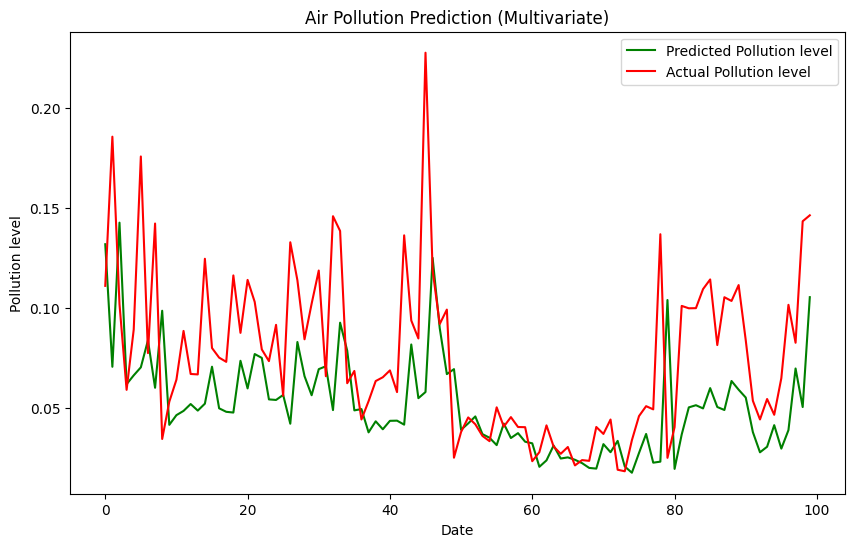

<Figure size 640x480 with 0 Axes>

In [ ]:
#Plot the graph between actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(Y_pred[:100,:], color= 'green',label = 'Predicted Pollution level')
plt.plot(Y_test[:100,:] , color = 'red',label = 'Actual Pollution level')
plt.title("Air Pollution Prediction (Multivariate)")
plt.xlabel("Date")
plt.ylabel("Pollution level")
plt.legend()
plt.show()
plt.savefig('graph.png')

CNN


In [ ]:
#creates a new DataFrame called pm_data by selecting specific columns ('PM10', 'PM2.5', 'AQI')

cnn_pm_data=ftd_pollution_data[['PM10','PM2.5','AQI']]
#pm_data = pm_data.set_index('Datetime')

In [ ]:
# Check for the count of missing values in each column of pm_data
cnn_pm_data.isnull().sum()

PM10     3868
PM2.5    1424
AQI      1347
dtype: int64

In [ ]:
# Check for the count of NaN values in each column of pm_data
cnn_pm_data.isna().sum()

PM10     3868
PM2.5    1424
AQI      1347
dtype: int64

In [ ]:
# Drop rows with missing values from pm_data DataFrame
cnn_pm_data.dropna(inplace=True)

<ipython-input-54-4b8ac57683bc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnn_pm_data.dropna(inplace=True)


In [ ]:
cnn_pm_data.shape

(13746, 3)

In [ ]:
cnn_pm_data.head()

,PM10,PM2.5,AQI
1595,122.41,37.55,281.0
1596,116.32,33.97,330.0
1597,130.07,35.48,356.0
1598,138.31,34.11,359.0
1599,111.73,33.69,547.0


<Axes: >

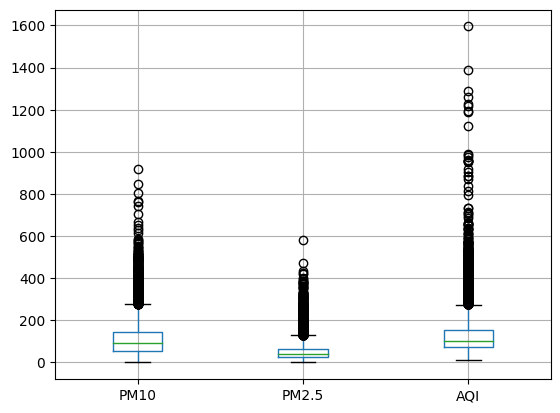

In [ ]:
cnn_pm_data.boxplot()

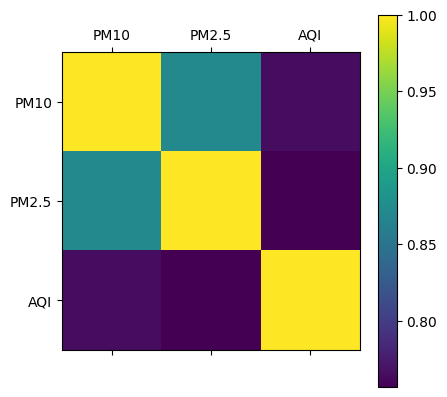

In [ ]:
dataset_columns = cnn_pm_data.columns.tolist()
cor_cols = dataset_columns
plt.matshow(cnn_pm_data.corr())
plt.xticks(range(len(cor_cols)), cor_cols)
plt.yticks(range(len(cor_cols)), cor_cols)
plt.colorbar()
plt.show()

In [ ]:
import numpy as np

# Splitting the dataset into independent and dependent variables
X = cnn_pm_data[['PM10','PM2.5']].values
Y = cnn_pm_data['AQI'].values

# Define the time step size
time_step = 30

# Create input sequences and corresponding target values
X_sequences = []
Y_targets = []

for i in range(len(X) - time_step):
    X_sequences.append(X[i:i+time_step])
    Y_targets.append(Y[i+time_step])

# Convert the sequences and targets to NumPy arrays
X_sequences = np.array(X_sequences)
Y_targets = np.array(Y_targets)

# Reshape the input sequences to match the expected input shape of the CNN model
X_reshaped = X_sequences.reshape(X_sequences.shape[0], time_step, 2)

# Normalize/Preprocess your data if required

# Split the dataset into training and testing sets
train_size = int(len(X_reshaped) * 0.8)  # 80% for training
X_train = X_reshaped[:train_size]
Y_train = Y_targets[:train_size]
X_test = X_reshaped[train_size:]
Y_test = Y_targets[train_size:]


In [ ]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(30, 2)))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# fit model
model.fit(X_train, Y_train, epochs=200, verbose=0)

In [ ]:
preds = model.predict(X_test)


86/86 [==============================] - 0s 3ms/step


In [ ]:
preds


array([[295.562   ],
       [244.4518  ],
       [206.35808 ],
       ...,
       [109.75991 ],
       [150.69948 ],
       [125.755135]], dtype=float32)

In [ ]:
Y_test

array([186., 202., 223., ...,  68.,  54.,  50.])

In [ ]:


mae = mean_absolute_error(Y_test, preds)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(Y_test, preds)
rmse = np.sqrt(mse)
print("Mean Squared Error:",mse)
print("Root Mean Squared Error:", rmse)

r2 = r2_score(Y_test, preds)
print("R-squared score:", r2)


Mean Absolute Error: 39.34043443029198
Mean Squared Error: 3338.1008456254776
Root Mean Squared Error: 57.77630003405789
R-squared score: 0.44532687992444786


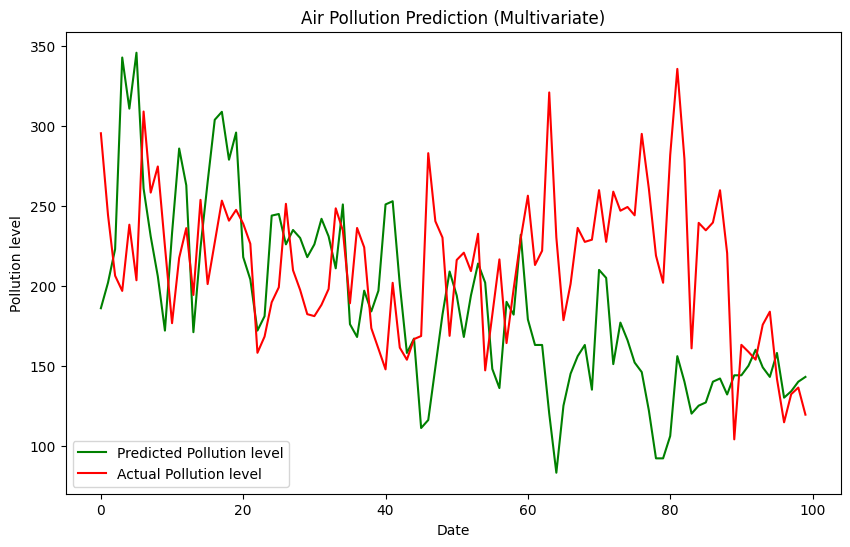

<Figure size 640x480 with 0 Axes>

In [ ]:
#Plot the graph between actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(Y_test[:100], color= 'green',label = 'Predicted Pollution level')
plt.plot(preds[:100,:] , color = 'red',label = 'Actual Pollution level')
plt.title("Air Pollution Prediction (Multivariate)")
plt.xlabel("Date")
plt.ylabel("Pollution level")
plt.legend()
plt.show()
plt.savefig('graph.png')

In [ ]:

#creates a new DataFrame called cnn_mt_data by selecting specific columns ('PM10', 'PM2.5', 'AQI')

cnn_mt_data=ftd_pollution_data[['NO','NO2','NOx','NH3','CO','SO2','O3','AQI']]

In [ ]:
# Check for the count of missing values in each column of pm_data
cnn_mt_data.isnull().sum()


NO     1072
NO2    1074
NOx    1481
NH3    3980
CO      954
SO2    1255
O3     1314
AQI    1347
dtype: int64

In [ ]:
# Check for the count of NaN values in each column of pm_data
cnn_mt_data.isna().sum()

NO     1072
NO2    1074
NOx    1481
NH3    3980
CO      954
SO2    1255
O3     1314
AQI    1347
dtype: int64

In [ ]:
# Drop rows with missing values from pm_data DataFrame
cnn_mt_data.dropna(inplace=True)

<ipython-input-70-fc288b9b2d18>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnn_mt_data.dropna(inplace=True)


In [ ]:
cnn_mt_data.shape

(12725, 8)

In [ ]:
cnn_mt_data.head()

,NO,NO2,NOx,NH3,CO,SO2,O3,AQI
2010,7.20,1.27,10.65,25.63,0.56,4.22,2.81,52.0
2011,7.19,0.91,10.37,29.16,0.57,4.46,0.18,60.0
2012,7.14,1.07,10.48,28.95,0.57,4.53,0.41,62.0
2013,7.09,0.36,9.73,28.41,0.48,4.63,0.30,70.0
2014,5.63,2.32,8.09,23.98,0.50,4.71,13.02,54.0


<Axes: >

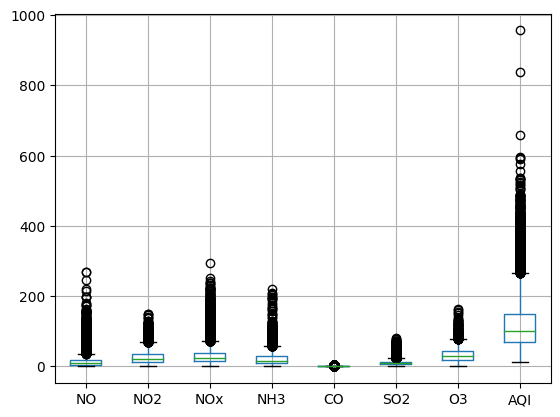

In [ ]:
cnn_mt_data.boxplot()

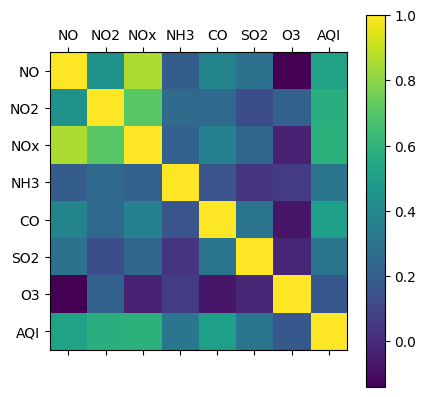

In [ ]:
dataset_columns = cnn_mt_data.columns.tolist()
cor_cols = dataset_columns
plt.matshow(cnn_mt_data.corr())
plt.xticks(range(len(cor_cols)), cor_cols)
plt.yticks(range(len(cor_cols)), cor_cols)
plt.colorbar()
plt.show()


In [ ]:
import numpy as np

# Splitting the dataset into independent and dependent variables
X = cnn_mt_data[['NO','NO2','NOx','NH3','CO','SO2','O3']].values
Y = cnn_mt_data['AQI'].values

# Define the time step size
time_step = 30

# Create input sequences and corresponding target values
X_sequences = []
Y_targets = []

for i in range(len(X) - time_step):
    X_sequences.append(X[i:i+time_step])
    Y_targets.append(Y[i+time_step])

# Convert the sequences and targets to NumPy arrays
X_sequences = np.array(X_sequences)
Y_targets = np.array(Y_targets)

# Reshape the input sequences to match the expected input shape of the CNN model
X_reshaped = X_sequences.reshape(X_sequences.shape[0], time_step, 7)

# Normalize/Preprocess your data if required

# Split the dataset into training and testing sets
train_size = int(len(X_reshaped) * 0.8)  # 80% for training
X_train = X_reshaped[:train_size]
Y_train = Y_targets[:train_size]
X_test = X_reshaped[train_size:]
Y_test = Y_targets[train_size:]

In [ ]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(30, 7)))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# fit model
model.fit(X_train, Y_train, epochs=200, verbose=0)

In [ ]:
preds = model.predict(X_test)


80/80 [==============================] - 0s 4ms/step


In [ ]:
preds

array([[231.36874 ],
       [183.35622 ],
       [218.56071 ],
       ...,
       [ 95.85928 ],
       [103.296875],
       [104.43773 ]], dtype=float32)

In [ ]:
Y_test

array([232., 179., 163., ...,  68.,  54.,  50.])

In [ ]:

mae = mean_absolute_error(Y_test, preds)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(Y_test, preds)
rmse = np.sqrt(mse)
print("Mean Squared Error:",mse)
print("Root Mean Squared Error:", rmse)

r2 = r2_score(Y_test, preds)
print("R-squared score:", r2)


Mean Absolute Error: 47.05041654976675
Mean Squared Error: 5099.466220035535
Root Mean Squared Error: 71.41054698036933
R-squared score: 0.0027373360498099686


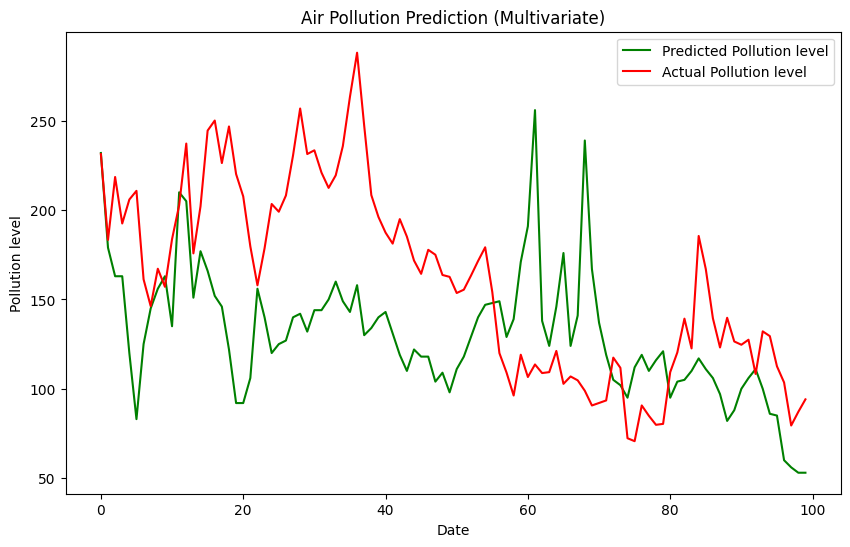

<Figure size 640x480 with 0 Axes>

In [ ]:
#Plot the graph between actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(Y_test[:100], color= 'green',label = 'Predicted Pollution level')
plt.plot(preds[:100,:] , color = 'red',label = 'Actual Pollution level')
plt.title("Air Pollution Prediction (Multivariate)")
plt.xlabel("Date")
plt.ylabel("Pollution level")
plt.legend()
plt.show()
plt.savefig('graph.png')

In [ ]:

#creates a new DataFrame called cnn_mt_data by selecting specific columns ('PM10', 'PM2.5', 'AQI')

cnn_cmb_data=ftd_pollution_data[['NO','NO2','NOx','NH3','CO','SO2','O3','AQI','PM10','PM2.5']]

In [ ]:
# Check for the count of missing values in each column of pm_data
cnn_cmb_data.isnull().sum()


NO       1072
NO2      1074
NOx      1481
NH3      3980
CO        954
SO2      1255
O3       1314
AQI      1347
PM10     3868
PM2.5    1424
dtype: int64

In [ ]:
# Check for the count of NaN values in each column of pm_data
cnn_cmb_data.isna().sum()

NO       1072
NO2      1074
NOx      1481
NH3      3980
CO        954
SO2      1255
O3       1314
AQI      1347
PM10     3868
PM2.5    1424
dtype: int64

In [ ]:
# Drop rows with missing values from pm_data DataFrame
cnn_cmb_data.dropna(inplace=True)

<ipython-input-86-f2785976c310>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnn_cmb_data.dropna(inplace=True)


In [ ]:
cnn_cmb_data.shape

(11093, 10)

In [ ]:
cnn_cmb_data.head()

,NO,NO2,NOx,NH3,CO,SO2,O3,AQI,PM10,PM2.5
2010,7.20,1.27,10.65,25.63,0.56,4.22,2.81,52.0,38.66,31.21
2011,7.19,0.91,10.37,29.16,0.57,4.46,0.18,60.0,46.68,38.39
2012,7.14,1.07,10.48,28.95,0.57,4.53,0.41,62.0,50.83,43.23
2013,7.09,0.36,9.73,28.41,0.48,4.63,0.30,70.0,41.03,33.82
2014,5.63,2.32,8.09,23.98,0.50,4.71,13.02,54.0,35.04,27.14


<Axes: >

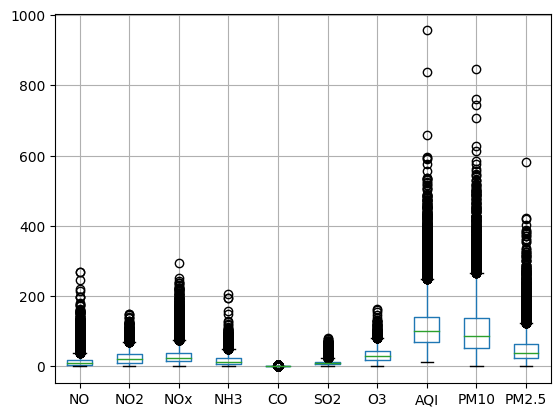

In [ ]:
cnn_cmb_data.boxplot()

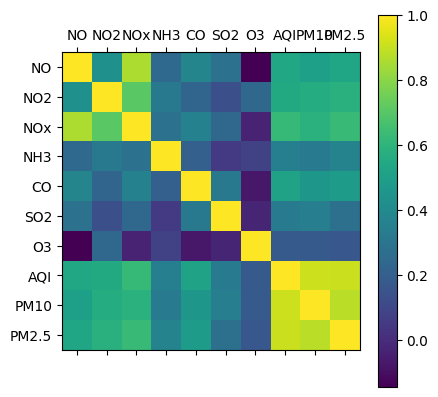

In [ ]:
dataset_columns = cnn_cmb_data.columns.tolist()
cor_cols = dataset_columns
plt.matshow(cnn_cmb_data.corr())
plt.xticks(range(len(cor_cols)), cor_cols)
plt.yticks(range(len(cor_cols)), cor_cols)
plt.colorbar()
plt.show()



In [ ]:
import numpy as np

# Splitting the dataset into independent and dependent variables
X = cnn_cmb_data[['NO','NO2','NOx','NH3','CO','SO2','O3','PM2.5','PM10']].values
Y = cnn_cmb_data['AQI'].values

# Define the time step size
time_step = 30

# Create input sequences and corresponding target values
X_sequences = []
Y_targets = []

for i in range(len(X) - time_step):
    X_sequences.append(X[i:i+time_step])
    Y_targets.append(Y[i+time_step])

# Convert the sequences and targets to NumPy arrays
X_sequences = np.array(X_sequences)
Y_targets = np.array(Y_targets)

# Reshape the input sequences to match the expected input shape of the CNN model
X_reshaped = X_sequences.reshape(X_sequences.shape[0], time_step, 9)

# Normalize/Preprocess your data if required

# Split the dataset into training and testing sets
train_size = int(len(X_reshaped) * 0.8)  # 80% for training
X_train = X_reshaped[:train_size]
Y_train = Y_targets[:train_size]
X_test = X_reshaped[train_size:]
Y_test = Y_targets[train_size:]

In [ ]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(30, 9)))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# fit model
model.fit(X_train, Y_train, epochs=10, verbose=1)

Epoch 1/10
277/277 [==============================] - 3s 5ms/step - loss: 2885.4072
Epoch 2/10
277/277 [==============================] - 1s 4ms/step - loss: 2218.1301
Epoch 3/10
277/277 [==============================] - 1s 4ms/step - loss: 2075.9819
Epoch 4/10
277/277 [==============================] - 2s 5ms/step - loss: 1997.7037
Epoch 5/10
277/277 [==============================] - 1s 5ms/step - loss: 1920.8590
Epoch 6/10
277/277 [==============================] - 1s 4ms/step - loss: 1847.8754
Epoch 7/10
277/277 [==============================] - 1s 4ms/step - loss: 1818.1600
Epoch 8/10
277/277 [==============================] - 1s 4ms/step - loss: 1769.0222
Epoch 9/10
277/277 [==============================] - 1s 4ms/step - loss: 1686.8777
Epoch 10/10
277/277 [==============================] - 1s 4ms/step - loss: 1618.9126


In [ ]:
preds = model.predict(X_test)


70/70 [==============================] - 0s 3ms/step


In [ ]:
preds

array([[27.778578],
       [31.762173],
       [27.275637],
       ...,
       [78.20747 ],
       [74.816185],
       [79.442474]], dtype=float32)

In [ ]:
Y_test

array([33., 41., 46., ..., 68., 54., 50.])

In [ ]:

mae = mean_absolute_error(Y_test, preds)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(Y_test, preds)
rmse = np.sqrt(mse)
print("Mean Squared Error:",mse)
print("Root Mean Squared Error:", rmse)

r2 = r2_score(Y_test, preds)
print("R-squared score:", r2)


Mean Absolute Error: 33.98001586976118
Mean Squared Error: 2766.366355479808
Root Mean Squared Error: 52.59625799883304
R-squared score: 0.48945677346920347


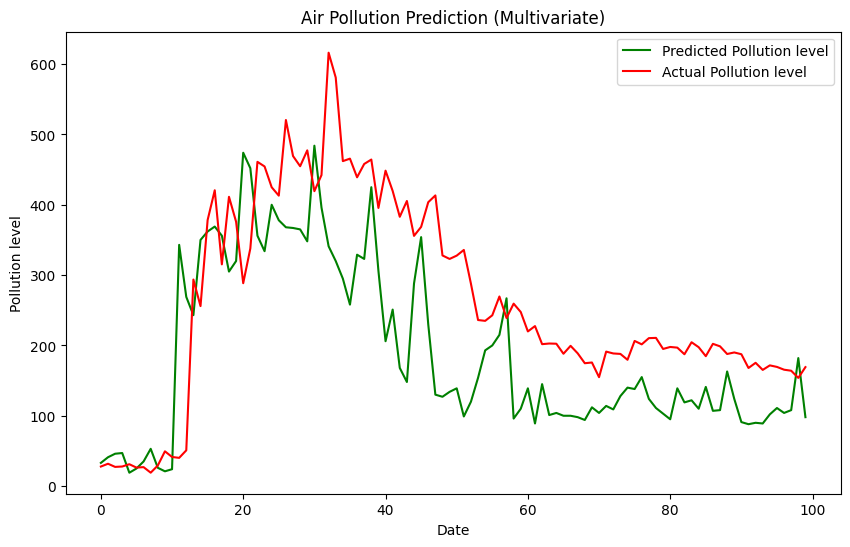

<Figure size 640x480 with 0 Axes>

In [ ]:
#Plot the graph between actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(Y_test[:100], color= 'green',label = 'Predicted Pollution level')
plt.plot(preds[:100,:] , color = 'red',label = 'Actual Pollution level')
plt.title("Air Pollution Prediction (Multivariate)")
plt.xlabel("Date")
plt.ylabel("Pollution level")
plt.legend()
plt.show()
plt.savefig('graph6.png')

**Explainability analysis of deep learning models**

shap value distribution of invidual feature

In [ ]:
#creates a new DataFrame called mt_data by selecting specific columns ('PM10', 'PM2.5', 'AQI')

cmb_data=ftd_pollution_data[['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','AQI']]


In [ ]:
cmb_data.isnull().sum()

PM2.5    1424
PM10     3868
NO       1072
NO2      1074
NOx      1481
NH3      3980
CO        954
SO2      1255
O3       1314
AQI      1347
dtype: int64

In [ ]:
cmb_data.isna().sum()

PM2.5    1424
PM10     3868
NO       1072
NO2      1074
NOx      1481
NH3      3980
CO        954
SO2      1255
O3       1314
AQI      1347
dtype: int64

In [ ]:
cmb_data.dropna(inplace=True)

<ipython-input-11-26dd01ff11ed>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cmb_data.dropna(inplace=True)


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 30.5 MB/s eta 0:00:00


In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 24.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=40f956eddd2fd7afa190cb4cdd101d785977557fd911237757a60c46a83be209
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import requests
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
import shap
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
shap.initjs()
import lime
import lime.lime_tabular
import matplotlib.pylab as pl
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [ ]:
#Importing LSTM model
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))



NameError: ignored